Based on https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py

In [1]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [2]:
import torch
import torch.nn as nn

# DO CONVNETS.

image_shape = (4, 28, 28)
latent_shape = (100,)

class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(-1, *self.shape)

# Discriminator
D = nn.Sequential(
        # Input: batch, 4, 28, 28

        nn.Conv2d(4, 8, kernel_size=5, stride=1, padding=2), # => batch, 4, 28, 28
        nn.BatchNorm2d(8),
        nn.LeakyReLU(0.2, True),
        nn.Dropout(0.2),

        nn.Conv2d(8, 32, kernel_size=5, stride=1, padding=2), # => batch, 32, 28, 28
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2, True),
        nn.Dropout(0.2),

        nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), # => batch, 64, 14, 14
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, True),
        nn.Dropout(0.2),

        #nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2), # => batch, 128, 7, 7
        #nn.BatchNorm2d(128),
        #nn.LeakyReLU(0.2, True),
        #nn.Dropout(0.2),

        Reshape(64*7*7), # => batch, 128*7*7

        #nn.Linear(128*7*7, 64), # => batch, 64
        #nn.LeakyReLU(0.2, True),
        #nn.Dropout(0.2),
        # nn.Linear(64, 64), # => batch, 64
        # nn.LeakyReLU(0.2, True),
        #nn.Linear(64, 1), # => batch, 1
        nn.Linear(64*7*7, 1),
        nn.Sigmoid()
)

# Generator
G = nn.Sequential(
        # ConvTranspose2d: next width or height := (prev_height - 1) * stride + kernel_size - padding * 2

        # https://distill.pub/2016/deconv-checkerboard/

        nn.Linear(100, 128*7*7),
        nn.LeakyReLU(0.2, True),

        Reshape(128, 7, 7), # b, 128, 7, 7

        nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, padding=2), # b, 64, 7, 7
        nn.BatchNorm2d(64), # nn.utils.SpectralNorm(),
        nn.UpsamplingNearest2d(scale_factor=2), # b, 64, 14, 14
        nn.LeakyReLU(0.2, True),

        nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1, padding=2), # b, 32, 14, 14
        nn.BatchNorm2d(32), # nn.utils.SpectralNorm(),
        nn.LeakyReLU(0.2, True),

        nn.ConvTranspose2d(32, 4, kernel_size=5, stride=1, padding=2), # b, 4, 14, 14
        nn.BatchNorm2d(4), # nn.utils.SpectralNorm(),
        nn.UpsamplingNearest2d(scale_factor=2), # b, 4, 28, 28

        nn.ConvTranspose2d(4, 4, kernel_size=5, stride=1, padding=2), # b, 4, 14, 14
        nn.BatchNorm2d(4), # nn.utils.SpectralNorm(),
        nn.Tanh()
)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.002)

def printthings(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print(self.__class__.__name__ + ': ', input[0].size(), "=>", output.data.size())

handles = [m.register_forward_hook(printthings) for m in D.modules()] \
        + [m.register_forward_hook(printthings) for m in G.modules()]
print("GENERATOR")
g_out = G(torch.randn(10, *latent_shape))
assert(g_out.size() == torch.randn(10, *image_shape).size())
print("DISCRIMINATOR")
d_out = D(g_out)
for handle in handles:
    handle.remove()

# Device setting
D = D.to(device)
G = G.to(device)

GENERATOR
Linear:  torch.Size([10, 100]) => torch.Size([10, 6272])
LeakyReLU:  torch.Size([10, 6272]) => torch.Size([10, 6272])
Reshape:  torch.Size([10, 6272]) => torch.Size([10, 128, 7, 7])
ConvTranspose2d:  torch.Size([10, 128, 7, 7]) => torch.Size([10, 64, 7, 7])
BatchNorm2d:  torch.Size([10, 64, 7, 7]) => torch.Size([10, 64, 7, 7])
UpsamplingNearest2d:  torch.Size([10, 64, 7, 7]) => torch.Size([10, 64, 14, 14])
LeakyReLU:  torch.Size([10, 64, 14, 14]) => torch.Size([10, 64, 14, 14])
ConvTranspose2d:  torch.Size([10, 64, 14, 14]) => torch.Size([10, 32, 14, 14])
BatchNorm2d:  torch.Size([10, 32, 14, 14]) => torch.Size([10, 32, 14, 14])
LeakyReLU:  torch.Size([10, 32, 14, 14]) => torch.Size([10, 32, 14, 14])
ConvTranspose2d:  torch.Size([10, 32, 14, 14]) => torch.Size([10, 4, 14, 14])
BatchNorm2d:  torch.Size([10, 4, 14, 14]) => torch.Size([10, 4, 14, 14])
UpsamplingNearest2d:  torch.Size([10, 4, 14, 14]) => torch.Size([10, 4, 28, 28])
Tanh:  torch.Size([10, 4, 28, 28]) => torch.Size

/home/nikola/anaconda3/envs/ml/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:177: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.")
/home/nikola/anaconda3/envs/ml/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


In [4]:
import h5py
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np

fname = 'dataset.hdf5'
dname = 'twitch_emotes'
with h5py.File(fname, 'r') as f:
    dataset = f[dname]
    preloaded_data = torch.Tensor(np.moveaxis(dataset[:50000], 3, 1)).to(device)
    print(preloaded_data.size())


torch.Size([50000, 4, 28, 28])


Epoch [0/50], Step [1/25], d_loss: 11344.4951, g_loss: 5670.5361, D(x): 0.50, D(G(z)): 0.51
Epoch [0/50], Step [2/25], d_loss: 11388.0020, g_loss: 5660.4419, D(x): 0.50, D(G(z)): 0.51
Epoch [0/50], Step [3/25], d_loss: 11404.4043, g_loss: 5649.8965, D(x): 0.50, D(G(z)): 0.51
Epoch [0/50], Step [4/25], d_loss: 11466.4824, g_loss: 5599.8936, D(x): 0.50, D(G(z)): 0.51
Epoch [0/50], Step [5/25], d_loss: 11603.5225, g_loss: 5510.5884, D(x): 0.49, D(G(z)): 0.52
Epoch [0/50], Step [6/25], d_loss: 11617.2500, g_loss: 5430.2046, D(x): 0.50, D(G(z)): 0.52
Epoch [0/50], Step [7/25], d_loss: 11691.1123, g_loss: 5362.0728, D(x): 0.50, D(G(z)): 0.53
Epoch [0/50], Step [8/25], d_loss: 11747.4043, g_loss: 5312.7061, D(x): 0.50, D(G(z)): 0.53
Epoch [0/50], Step [9/25], d_loss: 11834.1191, g_loss: 5244.3896, D(x): 0.49, D(G(z)): 0.53
Epoch [0/50], Step [10/25], d_loss: 11905.3291, g_loss: 5161.8433, D(x): 0.50, D(G(z)): 0.54
Epoch [0/50], Step [11/25], d_loss: 12051.4922, g_loss: 5067.9355, D(x): 0.50, 

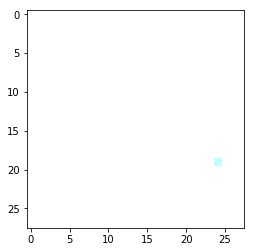

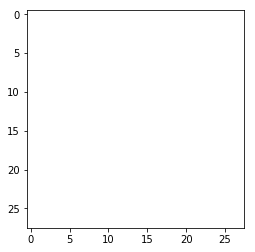

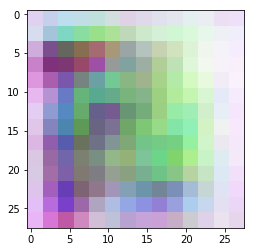

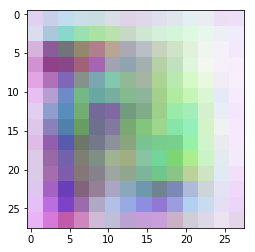

Epoch [1/50], Step [1/25], d_loss: 12013.8184, g_loss: 5516.7397, D(x): 0.47, D(G(z)): 0.52
Epoch [1/50], Step [2/25], d_loss: 11938.1123, g_loss: 5664.6069, D(x): 0.47, D(G(z)): 0.51
Epoch [1/50], Step [3/25], d_loss: 11843.3340, g_loss: 5815.3770, D(x): 0.46, D(G(z)): 0.50
Epoch [1/50], Step [4/25], d_loss: 11800.2598, g_loss: 5981.6416, D(x): 0.46, D(G(z)): 0.49
Epoch [1/50], Step [5/25], d_loss: 11796.8848, g_loss: 6142.9429, D(x): 0.45, D(G(z)): 0.48
Epoch [1/50], Step [6/25], d_loss: 11658.4199, g_loss: 6282.0615, D(x): 0.45, D(G(z)): 0.48
Epoch [1/50], Step [7/25], d_loss: 11557.8672, g_loss: 6410.7354, D(x): 0.45, D(G(z)): 0.47
Epoch [1/50], Step [8/25], d_loss: 11557.0547, g_loss: 6493.2256, D(x): 0.44, D(G(z)): 0.46
Epoch [1/50], Step [9/25], d_loss: 11552.9492, g_loss: 6555.9600, D(x): 0.44, D(G(z)): 0.46
Epoch [1/50], Step [10/25], d_loss: 11586.7764, g_loss: 6523.5127, D(x): 0.44, D(G(z)): 0.46
Epoch [1/50], Step [11/25], d_loss: 11661.0088, g_loss: 6397.0498, D(x): 0.44, 

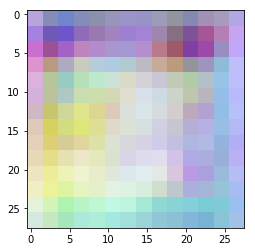

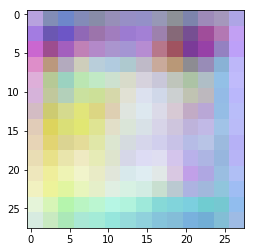

Epoch [2/50], Step [1/25], d_loss: 12213.3691, g_loss: 5181.0571, D(x): 0.48, D(G(z)): 0.54
Epoch [2/50], Step [2/25], d_loss: 12269.0391, g_loss: 5086.3472, D(x): 0.49, D(G(z)): 0.55
Epoch [2/50], Step [3/25], d_loss: 12326.0273, g_loss: 4966.2583, D(x): 0.49, D(G(z)): 0.55
Epoch [2/50], Step [4/25], d_loss: 12461.2500, g_loss: 4866.9971, D(x): 0.49, D(G(z)): 0.56
Epoch [2/50], Step [5/25], d_loss: 12622.9971, g_loss: 4757.7705, D(x): 0.49, D(G(z)): 0.57
Epoch [2/50], Step [6/25], d_loss: 12644.2197, g_loss: 4692.9619, D(x): 0.49, D(G(z)): 0.57
Epoch [2/50], Step [7/25], d_loss: 12683.4336, g_loss: 4623.2559, D(x): 0.49, D(G(z)): 0.58
Epoch [2/50], Step [8/25], d_loss: 12821.2539, g_loss: 4558.8784, D(x): 0.49, D(G(z)): 0.58
Epoch [2/50], Step [9/25], d_loss: 12850.4697, g_loss: 4518.5356, D(x): 0.49, D(G(z)): 0.58
Epoch [2/50], Step [10/25], d_loss: 12904.7617, g_loss: 4481.4644, D(x): 0.49, D(G(z)): 0.58
Epoch [2/50], Step [11/25], d_loss: 12996.7031, g_loss: 4478.8882, D(x): 0.49, 

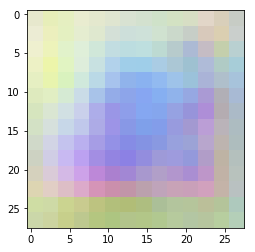

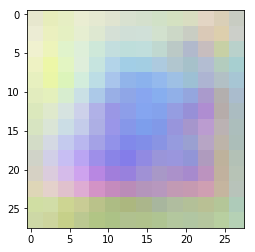

Epoch [3/50], Step [1/25], d_loss: 11984.9922, g_loss: 5889.0469, D(x): 0.45, D(G(z)): 0.50
Epoch [3/50], Step [2/25], d_loss: 11862.9336, g_loss: 6047.3198, D(x): 0.45, D(G(z)): 0.49
Epoch [3/50], Step [3/25], d_loss: 11818.8340, g_loss: 6170.3818, D(x): 0.45, D(G(z)): 0.48
Epoch [3/50], Step [4/25], d_loss: 11750.2217, g_loss: 6257.7598, D(x): 0.44, D(G(z)): 0.47
Epoch [3/50], Step [5/25], d_loss: 11774.3047, g_loss: 6326.3931, D(x): 0.44, D(G(z)): 0.47
Epoch [3/50], Step [6/25], d_loss: 11671.9639, g_loss: 6361.2500, D(x): 0.44, D(G(z)): 0.47
Epoch [3/50], Step [7/25], d_loss: 11663.4551, g_loss: 6360.5107, D(x): 0.44, D(G(z)): 0.46
Epoch [3/50], Step [8/25], d_loss: 11762.6650, g_loss: 6320.9409, D(x): 0.44, D(G(z)): 0.47
Epoch [3/50], Step [9/25], d_loss: 11781.3418, g_loss: 6234.6807, D(x): 0.44, D(G(z)): 0.47
Epoch [3/50], Step [10/25], d_loss: 11907.0107, g_loss: 6103.2881, D(x): 0.44, D(G(z)): 0.48
Epoch [3/50], Step [11/25], d_loss: 12031.1660, g_loss: 5951.7549, D(x): 0.44, 

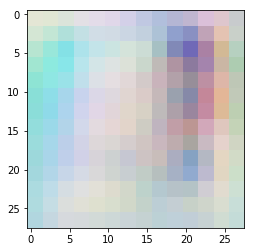

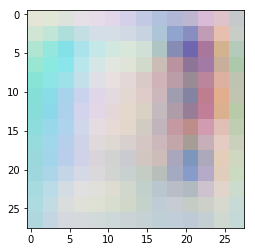

Epoch [4/50], Step [1/25], d_loss: 11572.7656, g_loss: 6096.6826, D(x): 0.46, D(G(z)): 0.48
Epoch [4/50], Step [2/25], d_loss: 11505.6191, g_loss: 6098.5396, D(x): 0.46, D(G(z)): 0.48
Epoch [4/50], Step [3/25], d_loss: 11457.9160, g_loss: 6115.9136, D(x): 0.46, D(G(z)): 0.48
Epoch [4/50], Step [4/25], d_loss: 11448.1240, g_loss: 6123.3828, D(x): 0.46, D(G(z)): 0.48
Epoch [4/50], Step [5/25], d_loss: 11505.6836, g_loss: 6130.3169, D(x): 0.46, D(G(z)): 0.48
Epoch [4/50], Step [6/25], d_loss: 11430.4922, g_loss: 6119.0986, D(x): 0.46, D(G(z)): 0.48
Epoch [4/50], Step [7/25], d_loss: 11450.3438, g_loss: 6109.0498, D(x): 0.46, D(G(z)): 0.48
Epoch [4/50], Step [8/25], d_loss: 11464.1875, g_loss: 6060.0840, D(x): 0.46, D(G(z)): 0.48
Epoch [4/50], Step [9/25], d_loss: 11466.3164, g_loss: 6022.8086, D(x): 0.46, D(G(z)): 0.48
Epoch [4/50], Step [10/25], d_loss: 11469.1670, g_loss: 5955.8628, D(x): 0.47, D(G(z)): 0.48
Epoch [4/50], Step [11/25], d_loss: 11540.9463, g_loss: 5878.4248, D(x): 0.47, 

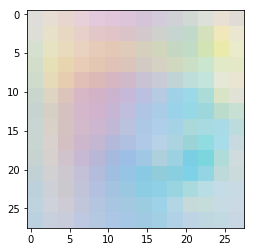

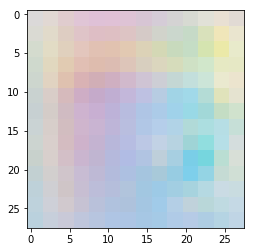

Epoch [5/50], Step [1/25], d_loss: 11873.9131, g_loss: 5650.2104, D(x): 0.46, D(G(z)): 0.51
Epoch [5/50], Step [2/25], d_loss: 11819.4385, g_loss: 5688.2231, D(x): 0.46, D(G(z)): 0.50
Epoch [5/50], Step [3/25], d_loss: 11821.4707, g_loss: 5677.6924, D(x): 0.46, D(G(z)): 0.50
Epoch [5/50], Step [4/25], d_loss: 11884.2041, g_loss: 5668.5757, D(x): 0.46, D(G(z)): 0.50
Epoch [5/50], Step [5/25], d_loss: 11959.4199, g_loss: 5637.4849, D(x): 0.46, D(G(z)): 0.51
Epoch [5/50], Step [6/25], d_loss: 11992.8223, g_loss: 5607.0439, D(x): 0.46, D(G(z)): 0.51
Epoch [5/50], Step [7/25], d_loss: 12018.7246, g_loss: 5590.5190, D(x): 0.46, D(G(z)): 0.51
Epoch [5/50], Step [8/25], d_loss: 12124.3418, g_loss: 5562.8423, D(x): 0.45, D(G(z)): 0.51
Epoch [5/50], Step [9/25], d_loss: 12110.2246, g_loss: 5528.4180, D(x): 0.46, D(G(z)): 0.51
Epoch [5/50], Step [10/25], d_loss: 12156.9180, g_loss: 5510.9565, D(x): 0.45, D(G(z)): 0.51
Epoch [5/50], Step [11/25], d_loss: 12227.3887, g_loss: 5484.9321, D(x): 0.45, 

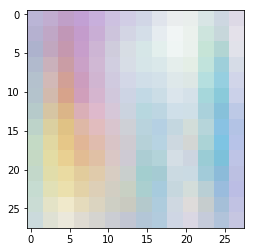

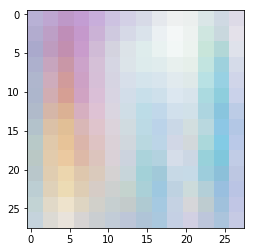

Epoch [6/50], Step [1/25], d_loss: 12219.7383, g_loss: 5770.1230, D(x): 0.44, D(G(z)): 0.50
Epoch [6/50], Step [2/25], d_loss: 12111.4199, g_loss: 5812.6748, D(x): 0.44, D(G(z)): 0.50
Epoch [6/50], Step [3/25], d_loss: 12027.5186, g_loss: 5836.3867, D(x): 0.44, D(G(z)): 0.49
Epoch [6/50], Step [4/25], d_loss: 11955.8691, g_loss: 5875.4858, D(x): 0.45, D(G(z)): 0.49
Epoch [6/50], Step [5/25], d_loss: 11877.9482, g_loss: 5889.6685, D(x): 0.45, D(G(z)): 0.49
Epoch [6/50], Step [6/25], d_loss: 11808.8643, g_loss: 5908.5176, D(x): 0.45, D(G(z)): 0.49
Epoch [6/50], Step [7/25], d_loss: 11771.5176, g_loss: 5901.6284, D(x): 0.45, D(G(z)): 0.49
Epoch [6/50], Step [8/25], d_loss: 11727.3975, g_loss: 5896.7788, D(x): 0.45, D(G(z)): 0.49
Epoch [6/50], Step [9/25], d_loss: 11667.9814, g_loss: 5863.8193, D(x): 0.46, D(G(z)): 0.49
Epoch [6/50], Step [10/25], d_loss: 11643.3398, g_loss: 5850.2534, D(x): 0.46, D(G(z)): 0.49
Epoch [6/50], Step [11/25], d_loss: 11628.8066, g_loss: 5826.6543, D(x): 0.46, 

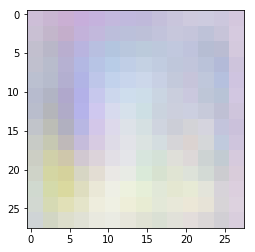

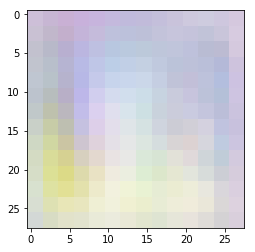

Epoch [7/50], Step [1/25], d_loss: 10892.7920, g_loss: 5893.0361, D(x): 0.50, D(G(z)): 0.49
Epoch [7/50], Step [2/25], d_loss: 10880.9180, g_loss: 5854.4438, D(x): 0.51, D(G(z)): 0.49
Epoch [7/50], Step [3/25], d_loss: 10902.7930, g_loss: 5780.3115, D(x): 0.51, D(G(z)): 0.49
Epoch [7/50], Step [4/25], d_loss: 10972.2520, g_loss: 5715.0371, D(x): 0.51, D(G(z)): 0.50
Epoch [7/50], Step [5/25], d_loss: 11028.9883, g_loss: 5644.9800, D(x): 0.51, D(G(z)): 0.50
Epoch [7/50], Step [6/25], d_loss: 11081.4395, g_loss: 5535.3569, D(x): 0.51, D(G(z)): 0.51
Epoch [7/50], Step [7/25], d_loss: 11199.2148, g_loss: 5427.9277, D(x): 0.51, D(G(z)): 0.52
Epoch [7/50], Step [8/25], d_loss: 11369.5273, g_loss: 5288.6455, D(x): 0.51, D(G(z)): 0.53
Epoch [7/50], Step [9/25], d_loss: 11526.1641, g_loss: 5114.2554, D(x): 0.51, D(G(z)): 0.54
Epoch [7/50], Step [10/25], d_loss: 11693.3447, g_loss: 4947.7964, D(x): 0.52, D(G(z)): 0.55
Epoch [7/50], Step [11/25], d_loss: 11802.6982, g_loss: 4864.9360, D(x): 0.51, 

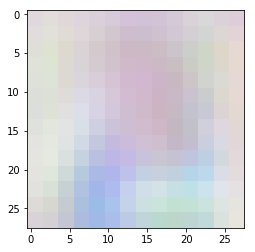

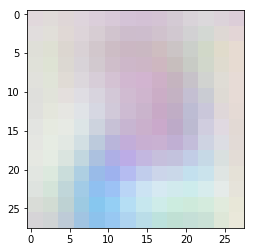

Epoch [8/50], Step [1/25], d_loss: 11392.5215, g_loss: 5800.3242, D(x): 0.48, D(G(z)): 0.50
Epoch [8/50], Step [2/25], d_loss: 11372.7617, g_loss: 5875.2461, D(x): 0.48, D(G(z)): 0.49
Epoch [8/50], Step [3/25], d_loss: 11391.7646, g_loss: 5915.4854, D(x): 0.48, D(G(z)): 0.49
Epoch [8/50], Step [4/25], d_loss: 11431.6777, g_loss: 5920.3691, D(x): 0.47, D(G(z)): 0.49
Epoch [8/50], Step [5/25], d_loss: 11486.0977, g_loss: 5924.0137, D(x): 0.47, D(G(z)): 0.49
Epoch [8/50], Step [6/25], d_loss: 11516.9238, g_loss: 5917.3027, D(x): 0.47, D(G(z)): 0.49
Epoch [8/50], Step [7/25], d_loss: 11558.4746, g_loss: 5906.6592, D(x): 0.47, D(G(z)): 0.49
Epoch [8/50], Step [8/25], d_loss: 11606.7676, g_loss: 5892.7075, D(x): 0.46, D(G(z)): 0.49
Epoch [8/50], Step [9/25], d_loss: 11663.6357, g_loss: 5858.3848, D(x): 0.46, D(G(z)): 0.49
Epoch [8/50], Step [10/25], d_loss: 11673.3828, g_loss: 5837.3169, D(x): 0.46, D(G(z)): 0.49
Epoch [8/50], Step [11/25], d_loss: 11751.5332, g_loss: 5839.2549, D(x): 0.46, 

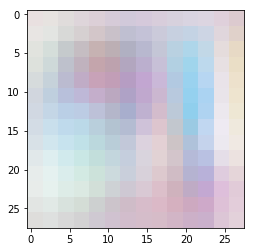

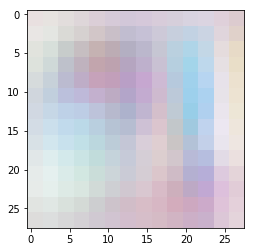

Epoch [9/50], Step [1/25], d_loss: 11004.1162, g_loss: 6758.0557, D(x): 0.45, D(G(z)): 0.44
Epoch [9/50], Step [2/25], d_loss: 10988.1387, g_loss: 6729.7720, D(x): 0.46, D(G(z)): 0.44
Epoch [9/50], Step [3/25], d_loss: 10990.3926, g_loss: 6669.1592, D(x): 0.46, D(G(z)): 0.44
Epoch [9/50], Step [4/25], d_loss: 11031.6309, g_loss: 6592.8672, D(x): 0.46, D(G(z)): 0.45
Epoch [9/50], Step [5/25], d_loss: 11026.2188, g_loss: 6526.3428, D(x): 0.46, D(G(z)): 0.45
Epoch [9/50], Step [6/25], d_loss: 11059.6758, g_loss: 6447.2603, D(x): 0.46, D(G(z)): 0.45
Epoch [9/50], Step [7/25], d_loss: 11057.4346, g_loss: 6391.5088, D(x): 0.47, D(G(z)): 0.46
Epoch [9/50], Step [8/25], d_loss: 11083.6660, g_loss: 6347.8145, D(x): 0.47, D(G(z)): 0.46
Epoch [9/50], Step [9/25], d_loss: 11013.6250, g_loss: 6332.4307, D(x): 0.47, D(G(z)): 0.46
Epoch [9/50], Step [10/25], d_loss: 10986.7461, g_loss: 6314.8682, D(x): 0.47, D(G(z)): 0.46
Epoch [9/50], Step [11/25], d_loss: 10950.4199, g_loss: 6317.3452, D(x): 0.48, 

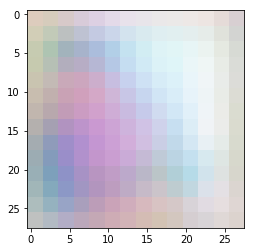

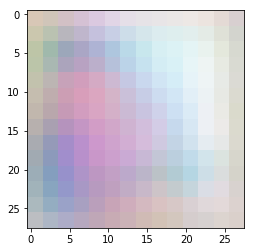

Epoch [10/50], Step [1/25], d_loss: 10571.6240, g_loss: 6090.8770, D(x): 0.51, D(G(z)): 0.48
Epoch [10/50], Step [2/25], d_loss: 10586.7148, g_loss: 6034.6387, D(x): 0.52, D(G(z)): 0.48
Epoch [10/50], Step [3/25], d_loss: 10601.4043, g_loss: 5971.9058, D(x): 0.52, D(G(z)): 0.49
Epoch [10/50], Step [4/25], d_loss: 10661.7754, g_loss: 5908.8091, D(x): 0.52, D(G(z)): 0.49
Epoch [10/50], Step [5/25], d_loss: 10658.1113, g_loss: 5839.8584, D(x): 0.53, D(G(z)): 0.49
Epoch [10/50], Step [6/25], d_loss: 10705.6318, g_loss: 5790.9731, D(x): 0.53, D(G(z)): 0.50
Epoch [10/50], Step [7/25], d_loss: 10717.9951, g_loss: 5748.6699, D(x): 0.53, D(G(z)): 0.50
Epoch [10/50], Step [8/25], d_loss: 10793.6172, g_loss: 5726.0635, D(x): 0.53, D(G(z)): 0.50
Epoch [10/50], Step [9/25], d_loss: 10779.2676, g_loss: 5698.3628, D(x): 0.53, D(G(z)): 0.50
Epoch [10/50], Step [10/25], d_loss: 10766.9160, g_loss: 5678.5132, D(x): 0.53, D(G(z)): 0.51
Epoch [10/50], Step [11/25], d_loss: 10790.1230, g_loss: 5683.9761, D

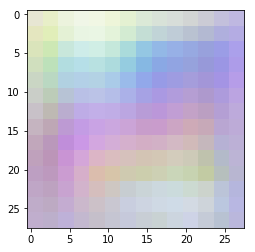

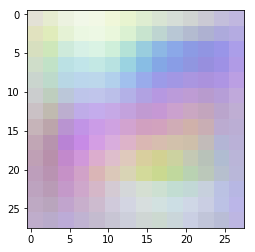

Epoch [11/50], Step [1/25], d_loss: 10934.8828, g_loss: 5338.9790, D(x): 0.55, D(G(z)): 0.53
Epoch [11/50], Step [2/25], d_loss: 10961.9697, g_loss: 5275.1890, D(x): 0.55, D(G(z)): 0.54
Epoch [11/50], Step [3/25], d_loss: 11023.7793, g_loss: 5220.6865, D(x): 0.55, D(G(z)): 0.54
Epoch [11/50], Step [4/25], d_loss: 11136.4902, g_loss: 5161.1914, D(x): 0.55, D(G(z)): 0.54
Epoch [11/50], Step [5/25], d_loss: 11283.7676, g_loss: 5133.8564, D(x): 0.55, D(G(z)): 0.55
Epoch [11/50], Step [6/25], d_loss: 11295.9668, g_loss: 5080.6147, D(x): 0.55, D(G(z)): 0.55
Epoch [11/50], Step [7/25], d_loss: 11365.7178, g_loss: 5032.0288, D(x): 0.55, D(G(z)): 0.55
Epoch [11/50], Step [8/25], d_loss: 11479.6230, g_loss: 4998.8955, D(x): 0.54, D(G(z)): 0.55
Epoch [11/50], Step [9/25], d_loss: 11455.7812, g_loss: 4997.1318, D(x): 0.54, D(G(z)): 0.55
Epoch [11/50], Step [10/25], d_loss: 11465.7432, g_loss: 5046.4614, D(x): 0.54, D(G(z)): 0.55
Epoch [11/50], Step [11/25], d_loss: 11488.1895, g_loss: 5093.5977, D

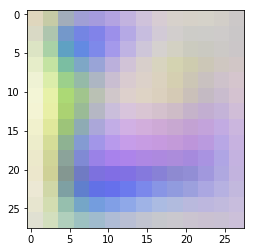

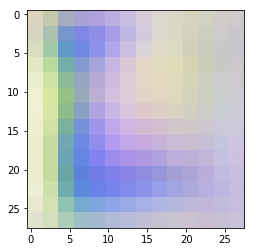

Epoch [12/50], Step [1/25], d_loss: 11426.7500, g_loss: 5584.1865, D(x): 0.50, D(G(z)): 0.51
Epoch [12/50], Step [2/25], d_loss: 11725.1484, g_loss: 5368.7378, D(x): 0.50, D(G(z)): 0.53
Epoch [12/50], Step [3/25], d_loss: 12027.4434, g_loss: 5168.5029, D(x): 0.49, D(G(z)): 0.54
Epoch [12/50], Step [4/25], d_loss: 12204.2275, g_loss: 5028.7544, D(x): 0.49, D(G(z)): 0.55
Epoch [12/50], Step [5/25], d_loss: 12427.7803, g_loss: 4957.9395, D(x): 0.49, D(G(z)): 0.56
Epoch [12/50], Step [6/25], d_loss: 12469.0293, g_loss: 4955.6074, D(x): 0.49, D(G(z)): 0.56
Epoch [12/50], Step [7/25], d_loss: 12497.5518, g_loss: 4994.8853, D(x): 0.48, D(G(z)): 0.56
Epoch [12/50], Step [8/25], d_loss: 12402.7207, g_loss: 5149.0083, D(x): 0.48, D(G(z)): 0.55
Epoch [12/50], Step [9/25], d_loss: 12166.1328, g_loss: 5325.6855, D(x): 0.48, D(G(z)): 0.54
Epoch [12/50], Step [10/25], d_loss: 12024.7168, g_loss: 5543.4883, D(x): 0.48, D(G(z)): 0.53
Epoch [12/50], Step [11/25], d_loss: 11869.3047, g_loss: 5769.6587, D

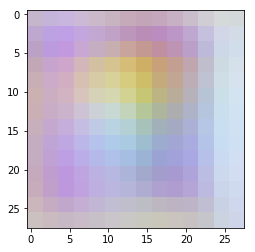

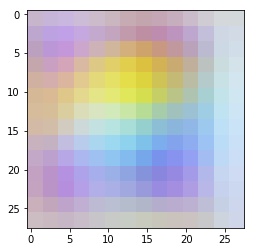

Epoch [13/50], Step [1/25], d_loss: 11204.9775, g_loss: 5983.3418, D(x): 0.49, D(G(z)): 0.49
Epoch [13/50], Step [2/25], d_loss: 11161.7441, g_loss: 5975.5400, D(x): 0.50, D(G(z)): 0.49
Epoch [13/50], Step [3/25], d_loss: 11157.8037, g_loss: 6008.5435, D(x): 0.50, D(G(z)): 0.49
Epoch [13/50], Step [4/25], d_loss: 11169.6758, g_loss: 6038.6523, D(x): 0.49, D(G(z)): 0.49
Epoch [13/50], Step [5/25], d_loss: 11178.1348, g_loss: 6100.4624, D(x): 0.49, D(G(z)): 0.49
Epoch [13/50], Step [6/25], d_loss: 11091.7383, g_loss: 6181.8774, D(x): 0.49, D(G(z)): 0.48
Epoch [13/50], Step [7/25], d_loss: 11040.8525, g_loss: 6248.4658, D(x): 0.49, D(G(z)): 0.48
Epoch [13/50], Step [8/25], d_loss: 11065.9277, g_loss: 6329.2974, D(x): 0.49, D(G(z)): 0.48
Epoch [13/50], Step [9/25], d_loss: 11010.7676, g_loss: 6351.7822, D(x): 0.49, D(G(z)): 0.47
Epoch [13/50], Step [10/25], d_loss: 11056.4258, g_loss: 6314.4268, D(x): 0.48, D(G(z)): 0.47
Epoch [13/50], Step [11/25], d_loss: 11176.6738, g_loss: 6253.2974, D

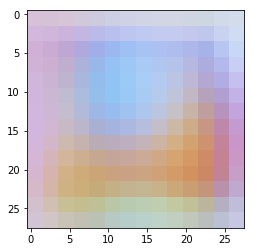

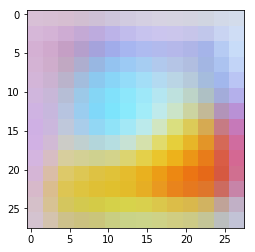

Epoch [14/50], Step [1/25], d_loss: 12332.7236, g_loss: 5619.1831, D(x): 0.46, D(G(z)): 0.52
Epoch [14/50], Step [2/25], d_loss: 12288.2969, g_loss: 5629.9946, D(x): 0.46, D(G(z)): 0.52
Epoch [14/50], Step [3/25], d_loss: 12206.5801, g_loss: 5705.5615, D(x): 0.46, D(G(z)): 0.52
Epoch [14/50], Step [4/25], d_loss: 12185.2793, g_loss: 5831.0366, D(x): 0.45, D(G(z)): 0.51
Epoch [14/50], Step [5/25], d_loss: 12045.7441, g_loss: 5976.9619, D(x): 0.45, D(G(z)): 0.50
Epoch [14/50], Step [6/25], d_loss: 11891.6436, g_loss: 6132.6230, D(x): 0.45, D(G(z)): 0.49
Epoch [14/50], Step [7/25], d_loss: 11714.3848, g_loss: 6306.3594, D(x): 0.45, D(G(z)): 0.48
Epoch [14/50], Step [8/25], d_loss: 11572.9209, g_loss: 6439.0791, D(x): 0.45, D(G(z)): 0.47
Epoch [14/50], Step [9/25], d_loss: 11407.4600, g_loss: 6568.1543, D(x): 0.45, D(G(z)): 0.46
Epoch [14/50], Step [10/25], d_loss: 11279.1445, g_loss: 6721.8975, D(x): 0.45, D(G(z)): 0.45
Epoch [14/50], Step [11/25], d_loss: 11205.4746, g_loss: 6807.5410, D

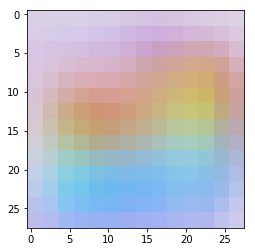

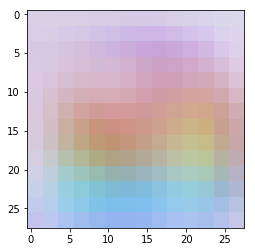

Epoch [15/50], Step [1/25], d_loss: 9706.8086, g_loss: 7453.5557, D(x): 0.51, D(G(z)): 0.41
Epoch [15/50], Step [2/25], d_loss: 9677.1367, g_loss: 7479.3457, D(x): 0.51, D(G(z)): 0.41
Epoch [15/50], Step [3/25], d_loss: 9625.1855, g_loss: 7462.5444, D(x): 0.51, D(G(z)): 0.41
Epoch [15/50], Step [4/25], d_loss: 9649.3516, g_loss: 7482.2495, D(x): 0.51, D(G(z)): 0.41
Epoch [15/50], Step [5/25], d_loss: 9645.4883, g_loss: 7414.3574, D(x): 0.51, D(G(z)): 0.41
Epoch [15/50], Step [6/25], d_loss: 9639.9297, g_loss: 7424.9219, D(x): 0.52, D(G(z)): 0.41
Epoch [15/50], Step [7/25], d_loss: 9659.4980, g_loss: 7364.4917, D(x): 0.52, D(G(z)): 0.41
Epoch [15/50], Step [8/25], d_loss: 9682.2949, g_loss: 7322.4976, D(x): 0.52, D(G(z)): 0.42
Epoch [15/50], Step [9/25], d_loss: 9676.4648, g_loss: 7266.6729, D(x): 0.52, D(G(z)): 0.42
Epoch [15/50], Step [10/25], d_loss: 9704.5039, g_loss: 7221.0840, D(x): 0.52, D(G(z)): 0.42
Epoch [15/50], Step [11/25], d_loss: 9794.7949, g_loss: 7171.3223, D(x): 0.52, 

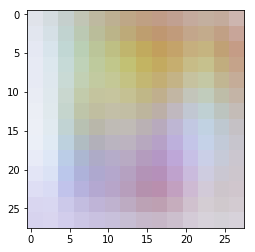

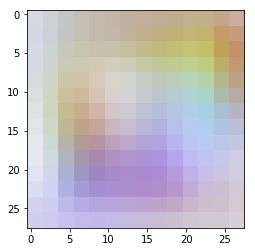

Epoch [16/50], Step [1/25], d_loss: 10379.6660, g_loss: 5916.2485, D(x): 0.55, D(G(z)): 0.49
Epoch [16/50], Step [2/25], d_loss: 10494.8398, g_loss: 5804.6533, D(x): 0.55, D(G(z)): 0.50
Epoch [16/50], Step [3/25], d_loss: 10554.9785, g_loss: 5683.6172, D(x): 0.55, D(G(z)): 0.51
Epoch [16/50], Step [4/25], d_loss: 10676.7598, g_loss: 5582.4204, D(x): 0.55, D(G(z)): 0.51
Epoch [16/50], Step [5/25], d_loss: 10920.1396, g_loss: 5476.7534, D(x): 0.55, D(G(z)): 0.52
Epoch [16/50], Step [6/25], d_loss: 10940.5508, g_loss: 5353.8638, D(x): 0.55, D(G(z)): 0.53
Epoch [16/50], Step [7/25], d_loss: 11150.8184, g_loss: 5213.4507, D(x): 0.55, D(G(z)): 0.54
Epoch [16/50], Step [8/25], d_loss: 11337.6191, g_loss: 5095.5264, D(x): 0.55, D(G(z)): 0.55
Epoch [16/50], Step [9/25], d_loss: 11447.7354, g_loss: 4927.8359, D(x): 0.56, D(G(z)): 0.56
Epoch [16/50], Step [10/25], d_loss: 11625.2676, g_loss: 4828.1680, D(x): 0.55, D(G(z)): 0.57
Epoch [16/50], Step [11/25], d_loss: 11851.4336, g_loss: 4762.9556, D

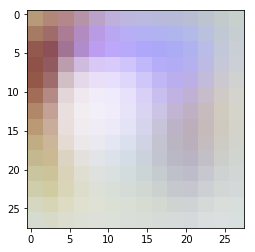

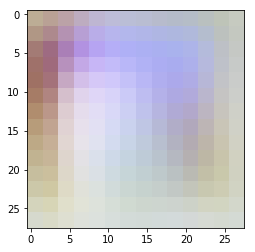

Epoch [17/50], Step [1/25], d_loss: 11451.3652, g_loss: 5387.7080, D(x): 0.52, D(G(z)): 0.53
Epoch [17/50], Step [2/25], d_loss: 11255.8828, g_loss: 5586.2935, D(x): 0.52, D(G(z)): 0.52
Epoch [17/50], Step [3/25], d_loss: 11121.7422, g_loss: 5756.4370, D(x): 0.52, D(G(z)): 0.51
Epoch [17/50], Step [4/25], d_loss: 11033.2676, g_loss: 5948.1914, D(x): 0.51, D(G(z)): 0.50
Epoch [17/50], Step [5/25], d_loss: 10920.5488, g_loss: 6109.5620, D(x): 0.51, D(G(z)): 0.49
Epoch [17/50], Step [6/25], d_loss: 10745.1699, g_loss: 6285.5552, D(x): 0.51, D(G(z)): 0.48
Epoch [17/50], Step [7/25], d_loss: 10667.7549, g_loss: 6418.7861, D(x): 0.51, D(G(z)): 0.47
Epoch [17/50], Step [8/25], d_loss: 10561.5020, g_loss: 6549.9976, D(x): 0.51, D(G(z)): 0.46
Epoch [17/50], Step [9/25], d_loss: 10435.4102, g_loss: 6663.1709, D(x): 0.51, D(G(z)): 0.46
Epoch [17/50], Step [10/25], d_loss: 10364.7188, g_loss: 6773.8896, D(x): 0.51, D(G(z)): 0.45
Epoch [17/50], Step [11/25], d_loss: 10364.1699, g_loss: 6810.2891, D

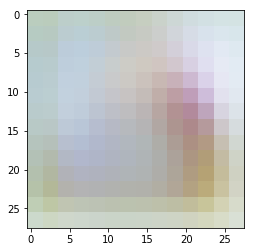

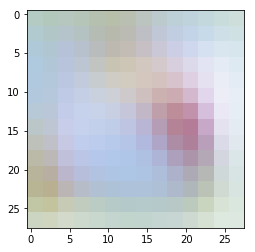

Epoch [18/50], Step [1/25], d_loss: 11226.5684, g_loss: 5608.4932, D(x): 0.52, D(G(z)): 0.52
Epoch [18/50], Step [2/25], d_loss: 11297.4707, g_loss: 5618.4043, D(x): 0.52, D(G(z)): 0.52
Epoch [18/50], Step [3/25], d_loss: 11312.7783, g_loss: 5588.2979, D(x): 0.52, D(G(z)): 0.52
Epoch [18/50], Step [4/25], d_loss: 11382.0625, g_loss: 5622.7051, D(x): 0.51, D(G(z)): 0.52
Epoch [18/50], Step [5/25], d_loss: 11374.7842, g_loss: 5729.1992, D(x): 0.51, D(G(z)): 0.51
Epoch [18/50], Step [6/25], d_loss: 11192.5635, g_loss: 5791.8867, D(x): 0.51, D(G(z)): 0.50
Epoch [18/50], Step [7/25], d_loss: 11124.8643, g_loss: 5910.0293, D(x): 0.51, D(G(z)): 0.50
Epoch [18/50], Step [8/25], d_loss: 11011.3887, g_loss: 6122.9316, D(x): 0.51, D(G(z)): 0.49
Epoch [18/50], Step [9/25], d_loss: 10893.4297, g_loss: 6266.9189, D(x): 0.51, D(G(z)): 0.48
Epoch [18/50], Step [10/25], d_loss: 10764.5605, g_loss: 6380.4263, D(x): 0.50, D(G(z)): 0.47
Epoch [18/50], Step [11/25], d_loss: 10686.9004, g_loss: 6540.4453, D

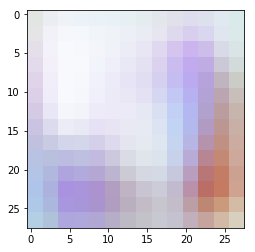

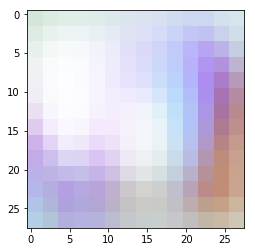

Epoch [19/50], Step [1/25], d_loss: 9729.5078, g_loss: 7235.2056, D(x): 0.53, D(G(z)): 0.43
Epoch [19/50], Step [2/25], d_loss: 9667.7373, g_loss: 7155.7749, D(x): 0.54, D(G(z)): 0.43
Epoch [19/50], Step [3/25], d_loss: 9680.0273, g_loss: 6987.7661, D(x): 0.54, D(G(z)): 0.43
Epoch [19/50], Step [4/25], d_loss: 9794.9805, g_loss: 6865.7520, D(x): 0.54, D(G(z)): 0.44
Epoch [19/50], Step [5/25], d_loss: 10011.4160, g_loss: 6652.6304, D(x): 0.54, D(G(z)): 0.45
Epoch [19/50], Step [6/25], d_loss: 10021.8008, g_loss: 6535.2197, D(x): 0.54, D(G(z)): 0.46
Epoch [19/50], Step [7/25], d_loss: 10128.4072, g_loss: 6349.1689, D(x): 0.54, D(G(z)): 0.47
Epoch [19/50], Step [8/25], d_loss: 10384.2188, g_loss: 6174.1514, D(x): 0.54, D(G(z)): 0.48
Epoch [19/50], Step [9/25], d_loss: 10429.3691, g_loss: 5972.1885, D(x): 0.55, D(G(z)): 0.49
Epoch [19/50], Step [10/25], d_loss: 10651.0791, g_loss: 5818.4106, D(x): 0.55, D(G(z)): 0.50
Epoch [19/50], Step [11/25], d_loss: 10767.5352, g_loss: 5697.4468, D(x):

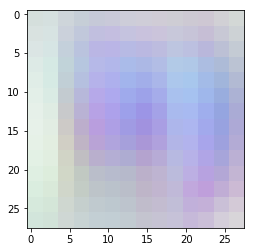

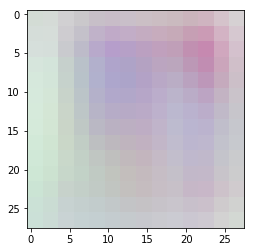

Epoch [20/50], Step [1/25], d_loss: 10618.6631, g_loss: 6143.4580, D(x): 0.54, D(G(z)): 0.50
Epoch [20/50], Step [2/25], d_loss: 10748.2793, g_loss: 6122.1650, D(x): 0.54, D(G(z)): 0.50
Epoch [20/50], Step [3/25], d_loss: 10904.7305, g_loss: 6116.9893, D(x): 0.53, D(G(z)): 0.50
Epoch [20/50], Step [4/25], d_loss: 11032.2598, g_loss: 6106.0430, D(x): 0.52, D(G(z)): 0.50
Epoch [20/50], Step [5/25], d_loss: 11165.4062, g_loss: 6127.7803, D(x): 0.51, D(G(z)): 0.50
Epoch [20/50], Step [6/25], d_loss: 11144.8438, g_loss: 6196.1543, D(x): 0.51, D(G(z)): 0.49
Epoch [20/50], Step [7/25], d_loss: 11226.3984, g_loss: 6245.9233, D(x): 0.50, D(G(z)): 0.49
Epoch [20/50], Step [8/25], d_loss: 11241.5664, g_loss: 6366.5220, D(x): 0.49, D(G(z)): 0.48
Epoch [20/50], Step [9/25], d_loss: 11138.3721, g_loss: 6445.2065, D(x): 0.49, D(G(z)): 0.48
Epoch [20/50], Step [10/25], d_loss: 11138.9736, g_loss: 6578.2329, D(x): 0.49, D(G(z)): 0.47
Epoch [20/50], Step [11/25], d_loss: 11092.1826, g_loss: 6707.3623, D

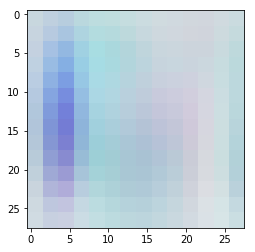

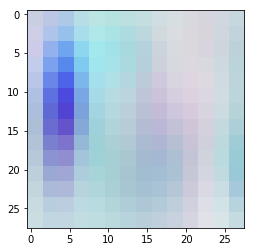

Epoch [21/50], Step [1/25], d_loss: 10735.4287, g_loss: 7113.5537, D(x): 0.48, D(G(z)): 0.44
Epoch [21/50], Step [2/25], d_loss: 10821.0488, g_loss: 7022.7354, D(x): 0.47, D(G(z)): 0.44
Epoch [21/50], Step [3/25], d_loss: 10835.5703, g_loss: 6938.0713, D(x): 0.47, D(G(z)): 0.44
Epoch [21/50], Step [4/25], d_loss: 10824.1641, g_loss: 6888.4497, D(x): 0.48, D(G(z)): 0.45
Epoch [21/50], Step [5/25], d_loss: 10892.7910, g_loss: 6825.0850, D(x): 0.48, D(G(z)): 0.45
Epoch [21/50], Step [6/25], d_loss: 10848.1855, g_loss: 6757.6577, D(x): 0.48, D(G(z)): 0.45
Epoch [21/50], Step [7/25], d_loss: 10917.5176, g_loss: 6661.9595, D(x): 0.48, D(G(z)): 0.46
Epoch [21/50], Step [8/25], d_loss: 10938.9434, g_loss: 6613.4106, D(x): 0.48, D(G(z)): 0.46
Epoch [21/50], Step [9/25], d_loss: 10880.1387, g_loss: 6542.0605, D(x): 0.49, D(G(z)): 0.46
Epoch [21/50], Step [10/25], d_loss: 10957.2227, g_loss: 6498.3101, D(x): 0.49, D(G(z)): 0.47
Epoch [21/50], Step [11/25], d_loss: 10979.9434, g_loss: 6444.9097, D

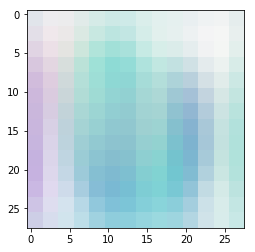

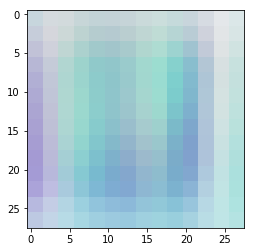

Epoch [22/50], Step [1/25], d_loss: 10406.9980, g_loss: 6948.6006, D(x): 0.50, D(G(z)): 0.44
Epoch [22/50], Step [2/25], d_loss: 10397.4531, g_loss: 6925.4629, D(x): 0.50, D(G(z)): 0.44
Epoch [22/50], Step [3/25], d_loss: 10423.7500, g_loss: 6863.6616, D(x): 0.51, D(G(z)): 0.45
Epoch [22/50], Step [4/25], d_loss: 10509.1211, g_loss: 6804.6064, D(x): 0.50, D(G(z)): 0.45
Epoch [22/50], Step [5/25], d_loss: 10566.0508, g_loss: 6732.7036, D(x): 0.50, D(G(z)): 0.45
Epoch [22/50], Step [6/25], d_loss: 10576.3027, g_loss: 6683.1064, D(x): 0.51, D(G(z)): 0.46
Epoch [22/50], Step [7/25], d_loss: 10624.2031, g_loss: 6608.5591, D(x): 0.51, D(G(z)): 0.46
Epoch [22/50], Step [8/25], d_loss: 10717.4111, g_loss: 6581.4248, D(x): 0.50, D(G(z)): 0.46
Epoch [22/50], Step [9/25], d_loss: 10643.7764, g_loss: 6578.3921, D(x): 0.51, D(G(z)): 0.47
Epoch [22/50], Step [10/25], d_loss: 10657.7305, g_loss: 6562.9556, D(x): 0.51, D(G(z)): 0.47
Epoch [22/50], Step [11/25], d_loss: 10698.6309, g_loss: 6574.4678, D

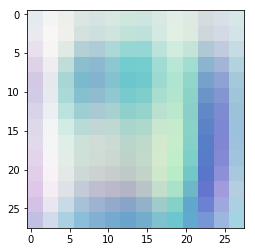

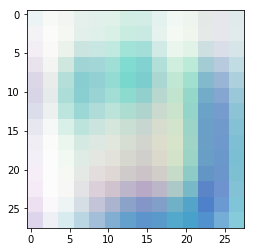

Epoch [23/50], Step [1/25], d_loss: 10051.0898, g_loss: 6634.0244, D(x): 0.55, D(G(z)): 0.46
Epoch [23/50], Step [2/25], d_loss: 10048.7559, g_loss: 6554.1689, D(x): 0.55, D(G(z)): 0.47
Epoch [23/50], Step [3/25], d_loss: 10077.7871, g_loss: 6448.2368, D(x): 0.56, D(G(z)): 0.47
Epoch [23/50], Step [4/25], d_loss: 10215.9941, g_loss: 6338.6309, D(x): 0.55, D(G(z)): 0.48
Epoch [23/50], Step [5/25], d_loss: 10290.4033, g_loss: 6189.7578, D(x): 0.56, D(G(z)): 0.49
Epoch [23/50], Step [6/25], d_loss: 10389.1602, g_loss: 6066.7988, D(x): 0.56, D(G(z)): 0.50
Epoch [23/50], Step [7/25], d_loss: 10438.4854, g_loss: 5940.8413, D(x): 0.56, D(G(z)): 0.50
Epoch [23/50], Step [8/25], d_loss: 10535.2705, g_loss: 5860.9478, D(x): 0.56, D(G(z)): 0.51
Epoch [23/50], Step [9/25], d_loss: 10533.3555, g_loss: 5840.2085, D(x): 0.56, D(G(z)): 0.51
Epoch [23/50], Step [10/25], d_loss: 10556.7598, g_loss: 5872.6064, D(x): 0.56, D(G(z)): 0.51
Epoch [23/50], Step [11/25], d_loss: 10568.3564, g_loss: 5966.7144, D

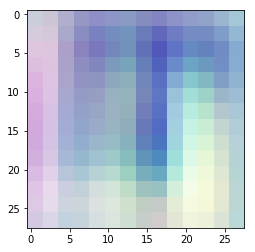

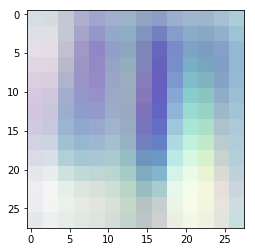

Epoch [24/50], Step [1/25], d_loss: 8394.3379, g_loss: 8946.2559, D(x): 0.56, D(G(z)): 0.36
Epoch [24/50], Step [2/25], d_loss: 8432.4473, g_loss: 8808.3799, D(x): 0.56, D(G(z)): 0.36
Epoch [24/50], Step [3/25], d_loss: 8546.7266, g_loss: 8585.9326, D(x): 0.56, D(G(z)): 0.37
Epoch [24/50], Step [4/25], d_loss: 8708.3945, g_loss: 8291.3037, D(x): 0.56, D(G(z)): 0.38
Epoch [24/50], Step [5/25], d_loss: 8817.6670, g_loss: 7950.1255, D(x): 0.56, D(G(z)): 0.39
Epoch [24/50], Step [6/25], d_loss: 8939.1348, g_loss: 7586.1904, D(x): 0.57, D(G(z)): 0.41
Epoch [24/50], Step [7/25], d_loss: 9183.9473, g_loss: 7224.3833, D(x): 0.57, D(G(z)): 0.43
Epoch [24/50], Step [8/25], d_loss: 9311.5654, g_loss: 6938.7627, D(x): 0.58, D(G(z)): 0.44
Epoch [24/50], Step [9/25], d_loss: 9512.9297, g_loss: 6625.7715, D(x): 0.58, D(G(z)): 0.46
Epoch [24/50], Step [10/25], d_loss: 9722.6719, g_loss: 6352.3892, D(x): 0.58, D(G(z)): 0.48
Epoch [24/50], Step [11/25], d_loss: 9993.7070, g_loss: 6075.5527, D(x): 0.58, 

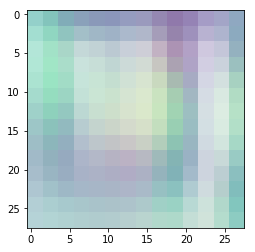

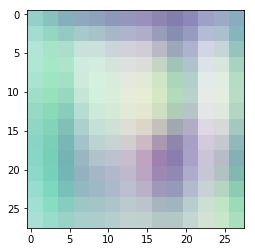

Epoch [25/50], Step [1/25], d_loss: 10325.2598, g_loss: 5543.0635, D(x): 0.61, D(G(z)): 0.54
Epoch [25/50], Step [2/25], d_loss: 10308.8496, g_loss: 5673.0039, D(x): 0.60, D(G(z)): 0.53
Epoch [25/50], Step [3/25], d_loss: 10259.9863, g_loss: 5824.8604, D(x): 0.60, D(G(z)): 0.52
Epoch [25/50], Step [4/25], d_loss: 10207.7256, g_loss: 5968.4175, D(x): 0.59, D(G(z)): 0.51
Epoch [25/50], Step [5/25], d_loss: 10118.4922, g_loss: 6108.0190, D(x): 0.59, D(G(z)): 0.50
Epoch [25/50], Step [6/25], d_loss: 9912.1289, g_loss: 6271.8462, D(x): 0.59, D(G(z)): 0.49
Epoch [25/50], Step [7/25], d_loss: 9849.3613, g_loss: 6457.5210, D(x): 0.58, D(G(z)): 0.49
Epoch [25/50], Step [8/25], d_loss: 9755.4590, g_loss: 6612.8350, D(x): 0.58, D(G(z)): 0.48
Epoch [25/50], Step [9/25], d_loss: 9662.4492, g_loss: 6764.2715, D(x): 0.58, D(G(z)): 0.47
Epoch [25/50], Step [10/25], d_loss: 9577.7930, g_loss: 6935.6841, D(x): 0.58, D(G(z)): 0.46
Epoch [25/50], Step [11/25], d_loss: 9591.2812, g_loss: 7038.6978, D(x): 0

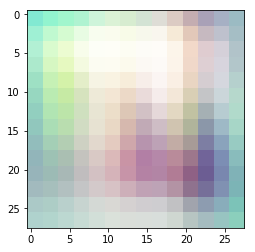

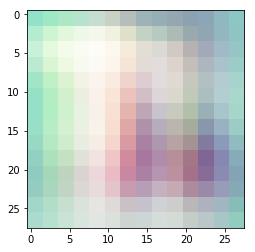

Epoch [26/50], Step [1/25], d_loss: 9245.6445, g_loss: 7370.0801, D(x): 0.58, D(G(z)): 0.43
Epoch [26/50], Step [2/25], d_loss: 9282.6484, g_loss: 7403.5088, D(x): 0.58, D(G(z)): 0.44
Epoch [26/50], Step [3/25], d_loss: 9314.6123, g_loss: 7372.3730, D(x): 0.58, D(G(z)): 0.44
Epoch [26/50], Step [4/25], d_loss: 9316.8223, g_loss: 7258.9990, D(x): 0.58, D(G(z)): 0.44
Epoch [26/50], Step [5/25], d_loss: 9435.3789, g_loss: 7197.7612, D(x): 0.58, D(G(z)): 0.44
Epoch [26/50], Step [6/25], d_loss: 9285.1895, g_loss: 7169.8604, D(x): 0.59, D(G(z)): 0.45
Epoch [26/50], Step [7/25], d_loss: 9332.4014, g_loss: 7047.6494, D(x): 0.59, D(G(z)): 0.45
Epoch [26/50], Step [8/25], d_loss: 9491.3867, g_loss: 6999.6763, D(x): 0.59, D(G(z)): 0.46
Epoch [26/50], Step [9/25], d_loss: 9410.2988, g_loss: 6814.7651, D(x): 0.60, D(G(z)): 0.46
Epoch [26/50], Step [10/25], d_loss: 9525.1455, g_loss: 6696.1401, D(x): 0.60, D(G(z)): 0.47
Epoch [26/50], Step [11/25], d_loss: 9624.2559, g_loss: 6518.6997, D(x): 0.60, 

KeyboardInterrupt: 

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

num_epochs = 50

batch_size = 2000

# Start training
total_step = len(preloaded_data) // batch_size
for epoch in range(num_epochs):
    for i in range(total_step):
        images = preloaded_data[batch_size * i : batch_size * (i+1)]
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = - torch.sum(torch.log(outputs)) # criterion(outputs, real_labels)
        real_score = outputs.mean().item()
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, *latent_shape).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = - torch.sum(torch.log1p(-outputs)) # criterion(outputs, fake_labels)
        fake_score = outputs.mean().item()
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        if d_loss > 0.5:
            reset_grad()
            d_loss.backward()
            d_optimizer.step()
        del d_loss_real, d_loss_fake
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #
        
        # Compute loss with fake images
        z = torch.randn(batch_size, *latent_shape).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = - torch.sum(torch.log(outputs)) # criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        # if (i+1) % 200 == 0:
        print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score, fake_score))
        del d_loss, g_loss
    
    # Save the model checkpoints 
    torch.save(G.state_dict(), 'G.ckpt')
    torch.save(D.state_dict(), 'D.ckpt')

    # Save real images
    if (epoch+1) == 1:
        for image in denorm(images).cpu().numpy()[0:2]:
            plt.figure()
            plt.imshow(np.moveaxis(image, 0, -1))
            plt.show()
    
    # Save sampled images
    for image in denorm(fake_images).cpu().detach().numpy()[0:2]:
        plt.figure()
        plt.imshow(np.moveaxis(image, 0, -1))
        plt.show()
